In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])            # 80% of data
Xdev, Ydev = build_dataset(words[n1:n2])        # 10% of data
Xte, Yte = build_dataset(words[n2:])            # 10% of data

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / ((n_embd * block_size)**0.5) # 0.2
b1 = torch.randn((n_hidden,),                       generator=g) * 0.1 # just for fun, its useless because of batch normalization
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1
b2 = torch.randn((vocab_size,),                     generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1
bnbias = torch.randn((1, n_hidden)) * 0.1

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad= True

4137


In [7]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [8]:
emb = C[Xb] #embed characters into vectors
embcat = emb.view(emb.shape[0], -1) # concat vectors
# Linear Layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm Layer
bnmeani = 1/n*hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(dim=0, keepdim=True) # note: Bessel's correction (dividing by n-1 instead of n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear Layer 2
logits = h @ W2 + b2 # output layer
# crross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch's autograd
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3343, grad_fn=<NegBackward0>)

In [ ]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

In [16]:
# embcat = emb.view(emb.shape[0], -1) 
emb.shape, C.shape, Xb.shape

# emb = C[Xb]

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [17]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
dprobs = (1.0/probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts # dnorm_logits = (norm_logits.exp()) * dcounts which is equal
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdims=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
dbnbias = dhpreact.sum(0, keepdims=True)
dbnraw = bngain * dhpreact
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)
dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff * dbndiff2)
dbnmeani = (-dbndiff).sum(dim=0)
dhprebn =  dbndiff.clone()
dhprebn +=  1.0/n * torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [18]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3343141078948975 diff: 2.384185791015625e-07


In [19]:
# backward pass

dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1.0
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


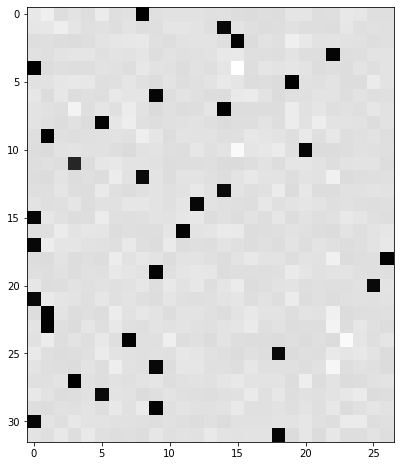

In [20]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [21]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [22]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [23]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  dlogits = F.softmax(logits, dim=1)
  dlogits[range(n), Yb] -= 1.0
  dlogits /= n
  # 2nd layer backprop
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  # tanh
  dhpreact = (1.0 - h**2) * dh
  # BatchNorm backprop
  dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
  dbnbias = dhpreact.sum(0, keepdims=True)
  dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
  # 1st layer backprop
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)
  # embedding backprop
  demb = dembcat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

12297
      0/ 200000: 3.8262


In [24]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.30385160446167e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09
(200,)          | exact: False | approximate: True  | maxdiff: 8.149072527885437e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.0954757928848267e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')